In [1]:
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 731.7/731.7 MB 1.3 MB/s eta 0:00:01
ERROR: Operation cancelled by user


In [ ]:
import torch
import torchvision
from torch import optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchmetrics import CalibrationError

In [ ]:
trainset = datasets.CIFAR100('cifar',
            train=True, download=True,
            transform=transforms.Compose([
                transforms.Resize((32, 32)),
                transforms.ToTensor()
            ]))

testset = datasets.CIFAR100('cifar', False,
                          transform = transforms.Compose([
                              transforms.Resize((32, 32)),
                              transforms.ToTensor()
                          ]))

trainset = DataLoader(trainset, batch_size=32, shuffle=True)
testset = DataLoader(testset, batch_size=32, shuffle=True)

100%|██████████| 169001437/169001437 [00:02<00:00, 69854269.27it/s]


Extracting cifar/cifar-100-python.tar.gz to cifar


**Define the Resnet and the Classifier**

In [ ]:
class Block(nn.Module):
    def __init__(self, num_layers, in_channels, out_channels, identity_downsample=None, stride=1):
        assert num_layers in [18, 34, 50, 101, 152], "should be a a valid architecture"
        super(Block, self).__init__()
        self.num_layers = num_layers
        if self.num_layers > 34:
            self.expansion = 4
        else:
            self.expansion = 1
        # ResNet50, 101, and 152 include additional layer of 1x1 kernels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        if self.num_layers > 34:
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        else:
            # for ResNet18 and 34, connect input directly to (3x3) kernel (skip first (1x1))
            self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        if self.num_layers > 34:
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

In [ ]:
class ResNet(nn.Module):
    def __init__(self, num_layers, block, image_channels, num_classes):
        assert num_layers in [18, 34, 50, 101, 152], f'ResNet{num_layers}: Unknown architecture! Number of layers has ' \
                                                     f'to be 18, 34, 50, 101, or 152 '
        super(ResNet, self).__init__()
        if num_layers < 50:
            self.expansion = 1
        else:
            self.expansion = 4
        if num_layers == 18:
            layers = [2, 2, 2, 2]
        elif num_layers == 34 or num_layers == 50:
            layers = [3, 4, 6, 3]
        elif num_layers == 101:
            layers = [3, 4, 23, 3]
        else:
            layers = [3, 8, 36, 3]
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Scaling Parameter
        self.init_scaling_factor = torch.ones(num_classes)
        self.scaling_factor = torch.nn.Parameter(self.init_scaling_factor, requires_grad=True)

        # ResNetLayers
        self.layer1 = self.make_layers(num_layers, block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers(num_layers, block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers(num_layers, block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers(num_layers, block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * self.expansion, num_classes)

        # softmax layer
        # self.softmax = torch.nn.Softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)/self.scaling_factor
        return x

    def make_layers(self, num_layers, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                            nn.BatchNorm2d(intermediate_channels*self.expansion))
        layers.append(block(num_layers, self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(num_layers, self.in_channels, intermediate_channels)) # 256 -> 64, 64*4 (256) again
        return nn.Sequential(*layers)

In [ ]:
def ResNet18(img_channels=3, num_classes=1000):
    return ResNet(18, Block, img_channels, num_classes)


def ResNet34(img_channels=3, num_classes=1000):
    return ResNet(34, Block, img_channels, num_classes)


def ResNet50(img_channels=3, num_classes=1000):
    return ResNet(50, Block, img_channels, num_classes)


def ResNet101(img_channels=3, num_classes=1000):
    return ResNet(101, Block, img_channels, num_classes)


def ResNet152(img_channels=3, num_classes=1000):
    return ResNet(152, Block, img_channels, num_classes)


def test():
    net = ResNet18(img_channels=3, num_classes=1000)
    y = net(torch.randn(4, 3, 224, 224)).to("cuda")
    print(y.size())

**Train the model**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet18(img_channels=3, num_classes=10).to(device)

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
error = CalibrationError(num_classes=10,
                         task='multiclass',norm='l1',n_bins=30)

In [ ]:
from tqdm import tqdm

num_epochs = 15
loss_li,acc_li, epoch_error  = [], [], []
for epoch in range(num_epochs):
    for idx, (x, label) in tqdm(enumerate(trainset),desc=f"Epoch {epoch+1}"):
        x, label = x.to(device), label.to(device)
#         print(x.shape, label.shape)
        logits = model(x) # b [b, 10]
        loss = criterion(logits, label) # label: [b]
        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # mapping the temperature to T>0 range
        model.scaling_factor.data.clamp_(min=0,max=float('Inf'))

    model.eval()
    with torch.no_grad():
        tot_corr = 0
        tot_num = 0
        epoch_calib_error = 0
        for x, label in testset:
            x, label = x.to(device), label.to(device)
            logits = model(x)
            pred = logits.argmax(dim=1)
            batch_calib_error = error(logits.softmax(dim=1).detach().cpu(),label.cpu())
            epoch_calib_error = epoch_calib_error + batch_calib_error
            # using item() to convert tensor to number
            tot_corr += torch.eq(pred, label).float().sum().item()
            tot_num += x.size(0)
        acc = tot_corr / tot_num

    loss_li.append(loss.item())
    acc_li.append(acc)
    epoch_error.append(epoch_calib_error)

    print('epoch: {}, loss: {}, acc: {}, error: {}'.format(epoch+1, loss, acc, epoch_calib_error))

Epoch 1: 1563it [07:43,  3.38it/s]


epoch: 1, loss: 1.2380850315093994, acc: 0.5514, error: 80.53853607177734


Epoch 2: 1563it [07:51,  3.31it/s]


epoch: 2, loss: 1.141409158706665, acc: 0.6294, error: 77.51318359375


Epoch 3: 1563it [08:20,  3.12it/s]


epoch: 3, loss: 1.1553411483764648, acc: 0.638, error: 77.28399658203125


Epoch 4: 1563it [08:24,  3.10it/s]


epoch: 4, loss: 0.7534688711166382, acc: 0.6967, error: 70.6339111328125


Epoch 5: 1563it [08:10,  3.19it/s]


epoch: 5, loss: 0.48389145731925964, acc: 0.6759, error: 72.94451141357422


Epoch 6: 1563it [08:47,  2.97it/s]


epoch: 6, loss: 0.6979690790176392, acc: 0.6769, error: 73.6539077758789


Epoch 7: 1563it [08:51,  2.94it/s]


epoch: 7, loss: 0.35066819190979004, acc: 0.7029, error: 69.62910461425781


Epoch 8: 1563it [08:48,  2.96it/s]


epoch: 8, loss: 0.300292044878006, acc: 0.7103, error: 68.33331298828125


Epoch 9: 1563it [08:47,  2.97it/s]


epoch: 9, loss: 0.7780159115791321, acc: 0.7161, error: 67.77657318115234


Epoch 10: 1563it [09:00,  2.89it/s]


epoch: 10, loss: 0.3405018150806427, acc: 0.7148, error: 68.7214126586914


Epoch 11: 1563it [08:48,  2.96it/s]


epoch: 11, loss: 0.9828429222106934, acc: 0.7199, error: 68.36919403076172


Epoch 12: 1563it [08:53,  2.93it/s]


epoch: 12, loss: 0.5103961825370789, acc: 0.7146, error: 71.01957702636719


Epoch 13: 1563it [08:53,  2.93it/s]


epoch: 13, loss: 0.3202936053276062, acc: 0.7128, error: 71.52162170410156


Epoch 14: 1563it [08:52,  2.93it/s]


epoch: 14, loss: 0.33300527930259705, acc: 0.7148, error: 72.17000579833984


Epoch 15: 1563it [08:42,  2.99it/s]


epoch: 15, loss: 0.11881805211305618, acc: 0.7166, error: 70.86544036865234


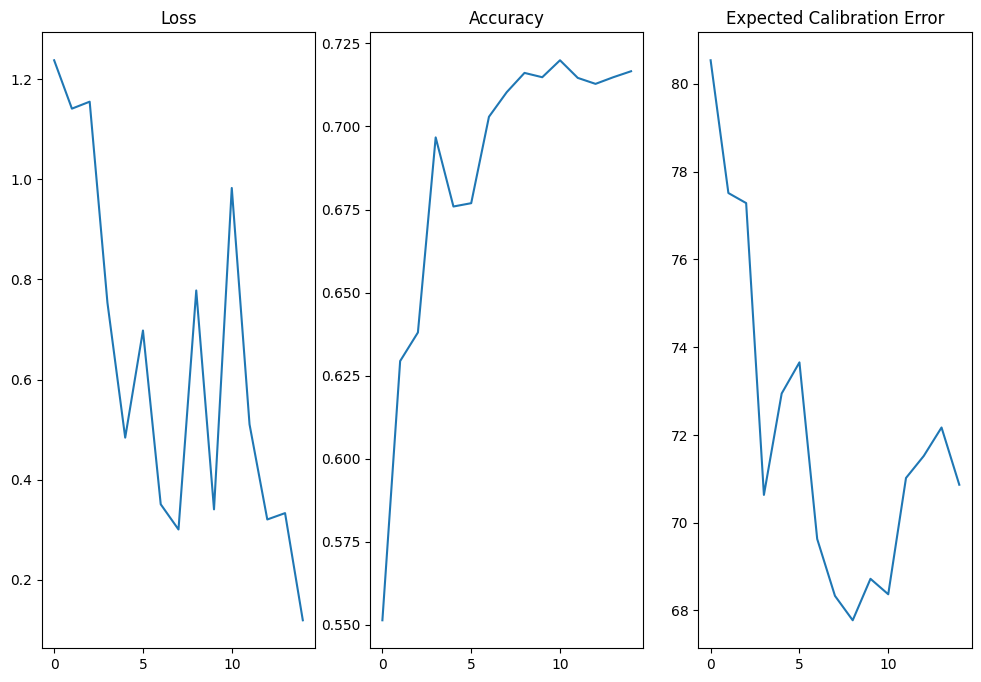

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 8))
ax[0].plot(loss_li)
ax[0].set_title('Loss')
ax[1].plot(acc_li)
ax[1].set_title('Accuracy')
ax[2].plot(epoch_error)
ax[2].set_title('Expected Calibration Error')
plt.show()

In [ ]:
import pandas as pd

metrics_df = pd.DataFrame({
    'Loss':loss_li,
    'Accuracy':acc_li,
    'ECE':epoch_error
}).reset_index(drop=False).rename(columns={'index':'Epoch'})
metrics_df

,Epoch,Loss,Accuracy,ECE
0,0,1.238085,0.5514,tensor(80.5385)
1,1,1.141409,0.6294,tensor(77.5132)
2,2,1.155341,0.6380,tensor(77.2840)
3,3,0.753469,0.6967,tensor(70.6339)
4,4,0.483891,0.6759,tensor(72.9445)
5,5,0.697969,0.6769,tensor(73.6539)
6,6,0.350668,0.7029,tensor(69.6291)
7,7,0.300292,0.7103,tensor(68.3333)
8,8,0.778016,0.7161,tensor(67.7766)
9,9,0.340502,0.7148,tensor(68.7214)
